<a href="https://colab.research.google.com/github/tanisaur/bikeshare-stations/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capital Bikeshare Station Optimization

##Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

##Read in Data

In [2]:
!wget -O bikeshare_data.parquet "https://2024-bikeshare.s3.us-west-2.amazonaws.com/2024_bikeshare_data.parquet"


--2025-01-26 21:01:54--  https://2024-bikeshare.s3.us-west-2.amazonaws.com/2024_bikeshare_data.parquet
Resolving 2024-bikeshare.s3.us-west-2.amazonaws.com (2024-bikeshare.s3.us-west-2.amazonaws.com)... 3.5.86.94, 52.92.210.50, 52.92.207.34, ...
Connecting to 2024-bikeshare.s3.us-west-2.amazonaws.com (2024-bikeshare.s3.us-west-2.amazonaws.com)|3.5.86.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202811622 (193M) [binary/octet-stream]
Saving to: ‘bikeshare_data.parquet’

bikeshare_data.parq 100%[===================>] 193.42M  20.4MB/s    in 10s     

2025-01-26 21:02:05 (18.5 MB/s) - ‘bikeshare_data.parquet’ saved [202811622/202811622]



In [3]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Capital Bikeshare/data/2024_bikeshare_data.parquet')

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7423C99F4BD5CA4D,classic_bike,2024-07-14 02:28:12.002000+00:00,2024-07-14 02:30:24.390000+00:00,15th St & N Scott St,31031.0,Clarendon Blvd & Pierce St,31016.0,38.890540,-77.080950,38.893438,-77.076389,member
1,C62B09A1D91AE9A1,electric_bike,2024-07-03 20:57:51.569000+00:00,2024-07-03 21:09:15.914000+00:00,Columbia Rd & Belmont St NW,31113.0,8th & V St NW,31134.0,38.920667,-77.043656,38.917716,-77.022684,member
2,7443CAB2293B4A0E,classic_bike,2024-07-15 20:09:01.187000+00:00,2024-07-15 20:26:56.526000+00:00,Hains Point/Buckeye & Ohio Dr SW,31273.0,Hains Point/Buckeye & Ohio Dr SW,31273.0,38.878433,-77.030230,38.878433,-77.030230,member
3,2BC3478A9E83046D,classic_bike,2024-07-31 20:26:34.406000+00:00,2024-07-31 22:29:45.352000+00:00,Long Bridge Aquatic Center,31950.0,Long Bridge Aquatic Center,31950.0,38.870561,-77.044095,38.870561,-77.044095,casual
4,11FDA598D980EE81,classic_bike,2024-07-31 20:26:16.461000+00:00,2024-07-31 22:29:32.309000+00:00,Long Bridge Aquatic Center,31950.0,Long Bridge Aquatic Center,31950.0,38.870561,-77.044095,38.870561,-77.044095,casual


## Clean Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079252 entries, 0 to 6079251
Data columns (total 13 columns):
 #   Column              Dtype              
---  ------              -----              
 0   ride_id             object             
 1   rideable_type       object             
 2   started_at          datetime64[ns, UTC]
 3   ended_at            datetime64[ns, UTC]
 4   start_station_name  object             
 5   start_station_id    float64            
 6   end_station_name    object             
 7   end_station_id      float64            
 8   start_lat           float64            
 9   start_lng           float64            
 10  end_lat             float64            
 11  end_lng             float64            
 12  member_casual       object             
dtypes: datetime64[ns, UTC](2), float64(6), object(5)
memory usage: 603.0+ MB


In [20]:
df.describe()

,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng
count,4.919630e+06,4.873044e+06,6.079252e+06,6.079251e+06,6.074606e+06,6.074606e+06
mean,3.137793e+04,3.137899e+04,3.890598e+01,-7.703220e+01,3.890526e+01,-7.703198e+01
std,2.863667e+02,2.875805e+02,2.836866e-02,3.668456e-02,3.073601e-02,4.160885e-02
min,3.020000e+04,3.020000e+04,3.800000e+01,-7.740000e+01,1.180000e+01,-8.018000e+01
25%,3.120800e+04,3.121200e+04,3.889287e+01,-7.704440e+01,3.889227e+01,-7.704442e+01
50%,3.128700e+04,3.128700e+04,3.890546e+01,-7.703000e+01,3.890383e+01,-7.703000e+01
75%,3.160900e+04,3.161000e+04,3.891902e+01,-7.701162e+01,3.891776e+01,-7.701082e+01
max,3.320000e+04,3.320000e+04,3.914000e+01,-7.678414e+01,4.307000e+01,-4.432000e+01


In [15]:
# Check for null values in each column
print(df.isnull().sum())

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1159622
start_station_id      1159622
end_station_name      1204685
end_station_id        1206208
start_lat                   0
start_lng                   1
end_lat                  4646
end_lng                  4646
member_casual               1
dtype: int64


You are able to unlock and lock e-bike outside of desinagted station. This could be indicator of full stations or not a nearby station.

In [16]:
#Check rows of missing data
missing_start = df[df['start_station_name'].isna()]
missing_end = df[df['end_station_name'].isna()]

# Preview the rows with missing values
print(missing_start.head())
print(missing_end.head())


              ride_id  rideable_type                       started_at  \
261  E82541C439387FC9  electric_bike 2024-07-29 07:48:38.448000+00:00   
262  9DBF500D1CC6AE61  electric_bike 2024-07-30 12:42:22.719000+00:00   
264  729C47FC0644E444  electric_bike 2024-07-09 09:12:07.806000+00:00   
265  C5F3CE566C41FCF8  electric_bike 2024-07-15 12:08:07.035000+00:00   
266  8A9846377F1DF3CB  electric_bike 2024-07-11 09:10:56.263000+00:00   

                            ended_at start_station_name  start_station_id  \
261 2024-07-29 08:05:04.563000+00:00               None               NaN   
262 2024-07-30 12:49:59.654000+00:00               None               NaN   
264 2024-07-09 09:20:19.996000+00:00               None               NaN   
265 2024-07-15 12:22:49.057000+00:00               None               NaN   
266 2024-07-11 09:25:01.591000+00:00               None               NaN   

                    end_station_name  end_station_id  start_lat  start_lng  \
261                 

It looks like some rides are not started at stations but end at stations and vice versa. Missing stations will be filled in with "no station"

In [25]:
df['start_station_name'].fillna('No Station', inplace=True)
df['end_station_name'].fillna('No Station', inplace=True)


In [18]:
# Count unique start station names
unique_start_stations = df['start_station_name'].nunique()
print(f"Number of unique start stations: {unique_start_stations}")

# List the unique start station names
print("\nList of unique start station names:")
print(df['start_station_name'].unique())

Number of unique start stations: 818

List of unique start station names:
['15th St & N Scott St' 'Columbia Rd & Belmont St NW'
 'Hains Point/Buckeye & Ohio Dr SW' 'Long Bridge Aquatic Center'
 'Columbia Rd & Georgia Ave NW' 'Rosedale Rec Center'
 'Georgia Ave & Kennedy St NW' '23rd & M St NW' '1st & L St NW'
 "Largo Rd & Campus Way / Prince Georges's Comm Col" '14th & L St NW'
 'New Hampshire Ave & Ward Pl NW' '15th & Euclid St NW' '18th & L St NW'
 '14th & Irving St NW' '4th & G St SW' '2nd St & Seaton Pl NE'
 '8th & Eye St SE / Barracks Row' 'Roosevelt Island'
 'Stadium Armory Metro' '4th & College St NW' 'M St & New Jersey Ave SE'
 'Pentagon City Metro / 12th St & S Hayes St' '17th & Corcoran St NW'
 'Rockville Pike & Rose Ave' '17th & K St NW' 'Rolfe St & 9th St S'
 'Wisconsin Ave & O St NW' '22nd & P ST NW'
 '10th St & Constitution Ave NW' 'Old Meadow Rd & Cathy Ln'
 'Shady Grove Metro East' '9th & N St NW' 'N Veitch St & 20th St N'
 'Connecticut Ave & McKinley St NW' '15th St & 

In [19]:
# Count unique start station names
unique_start_stations = df['end_station_name'].nunique()
print(f"Number of unique start stations: {unique_start_stations}")

# List the unique start station names
print("\nList of unique start station names:")
print(df['end_station_name'].unique())

Number of unique start stations: 818

List of unique start station names:
['Clarendon Blvd & Pierce St' '8th & V St NW'
 'Hains Point/Buckeye & Ohio Dr SW' 'Long Bridge Aquatic Center'
 '14th & Belmont St NW' 'No Station'
 'Massachusetts Ave & Dupont Circle NW' '3rd St & Pennsylvania Ave SE'
 "Largo Rd & Campus Way / Prince Georges's Comm Col" '15th & L St NW'
 '34th & Water St NW' '14th & G St NW' '15th & W St NW'
 'New Jersey Ave & R St NW' "Independence Ave & L'Enfant Plaza SW/DOE"
 'Gallaudet / 8th St & Florida Ave NE' 'Hamlin & 7th St NE'
 '15th St & Massachusetts Ave SE'
 'Smithsonian-National Mall / Jefferson Dr & 12th St SW'
 '19th St N & Ft Myer Dr' 'S Clark St & 33rd St'
 'Anacostia Ave & East Capitol St NE' '16th & Irving St NW'
 'St. Elizabeths West Campus/DHS\xa0' 'Eads St & 15th St S'
 '15th & P St NW' '18th & M St NW' 'Old Georgetown Rd & Southwick St'
 'Georgetown Harbor / 30th St NW' '5th & Morse St NE'
 'Wilson Blvd & N Quincy St' 'Columbia Rd & Belmont St NW' '9th & 

There are 817 unique stations throughout the DMV coverage area. The added 'No Station' filler is not included in this count.

In [21]:
# Check for unique ride_id
unique_ride_ids = df['ride_id'].nunique()
print(f"Number of unique ride IDs: {unique_ride_ids}")

# Check for duplicate ride_id
duplicate_ride_ids = df[df.duplicated(subset=['ride_id'], keep=False)]
if not duplicate_ride_ids.empty:
  print("Duplicate ride IDs found:")
  print(duplicate_ride_ids)
else:
  print("No duplicate ride IDs found.")

Number of unique ride IDs: 6079111
Duplicate ride IDs found:
                  ride_id  rideable_type                       started_at  \
1394467  A0D6E0D07416BB2A   classic_bike        2024-05-31 23:12:54+00:00   
1406038  3274F26728D10261   classic_bike        2024-05-31 20:58:48+00:00   
1408143  A9A7B0B468FBBE1B   classic_bike        2024-05-31 07:56:41+00:00   
1409793  3377EF31A5964D3C   classic_bike        2024-05-31 07:39:54+00:00   
1411060  59798416D0A9F527   classic_bike        2024-05-31 09:15:14+00:00   
...                   ...            ...                              ...   
6066999  B9258FFE87E5334C   classic_bike 2024-05-31 15:06:54.973000+00:00   
6068247  7560C440914B50A6  electric_bike 2024-05-31 23:54:22.733000+00:00   
6073258  D2477005900E798C  electric_bike 2024-05-31 23:53:10.471000+00:00   
6074495  120FF0AC298E453D   classic_bike 2024-05-31 23:38:09.785000+00:00   
6077414  05A2B6800F89AF43  electric_bike 2024-05-31 23:48:48.775000+00:00   

              

In [22]:
# Check for duplicate ride_id and remove them
duplicate_ride_ids = df[df.duplicated(subset=['ride_id'], keep=False)]
if not duplicate_ride_ids.empty:
  print("Duplicate ride IDs found:")
  print(duplicate_ride_ids)
  df = df.drop_duplicates(subset=['ride_id'], keep='first') #keep first occurence
  print("Duplicate ride IDs removed.")
else:
  print("No duplicate ride IDs found.")

Duplicate ride IDs found:
                  ride_id  rideable_type                       started_at  \
1394467  A0D6E0D07416BB2A   classic_bike        2024-05-31 23:12:54+00:00   
1406038  3274F26728D10261   classic_bike        2024-05-31 20:58:48+00:00   
1408143  A9A7B0B468FBBE1B   classic_bike        2024-05-31 07:56:41+00:00   
1409793  3377EF31A5964D3C   classic_bike        2024-05-31 07:39:54+00:00   
1411060  59798416D0A9F527   classic_bike        2024-05-31 09:15:14+00:00   
...                   ...            ...                              ...   
6066999  B9258FFE87E5334C   classic_bike 2024-05-31 15:06:54.973000+00:00   
6068247  7560C440914B50A6  electric_bike 2024-05-31 23:54:22.733000+00:00   
6073258  D2477005900E798C  electric_bike 2024-05-31 23:53:10.471000+00:00   
6074495  120FF0AC298E453D   classic_bike 2024-05-31 23:38:09.785000+00:00   
6077414  05A2B6800F89AF43  electric_bike 2024-05-31 23:48:48.775000+00:00   

                                ended_at  \
13944

In [30]:
df['start_station_id'].fillna(0, inplace=True)
df['end_station_id'].fillna(0, inplace=True)

In [31]:
print(df.isnull().sum())

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
start_station_id         0
end_station_name         0
end_station_id           0
start_lat                0
start_lng                1
end_lat               4633
end_lng               4633
member_casual            1
dtype: int64


In [48]:
# Group by the start station and count the number of trips
trips_per_start_station = df.groupby('start_station_name').size().reset_index(name='num_trips')

# Sort the stations by number of trips, descending
trips_per_start_station = trips_per_start_station.sort_values(by='num_trips', ascending=False)

# Display the results
print(trips_per_start_station)


                               start_station_name  num_trips
584                                    No Station    1159602
316               Columbus Circle / Union Station      55488
575                   New Hampshire Ave & T St NW      50671
66                                 15th & P St NW      43542
52                                 14th & V St NW      40969
..                                            ...        ...
531                       Minnesota Ave & D St SE          1
665          Roland Clarke Pl & Sunrise Valley Dr          1
741                    Tysons West Transit Center          1
274  Bowdoin Ave & Calvert Rd/ College Park Metro          1
658                      Ring Rd & North Shore Dr          1

[818 rows x 2 columns]


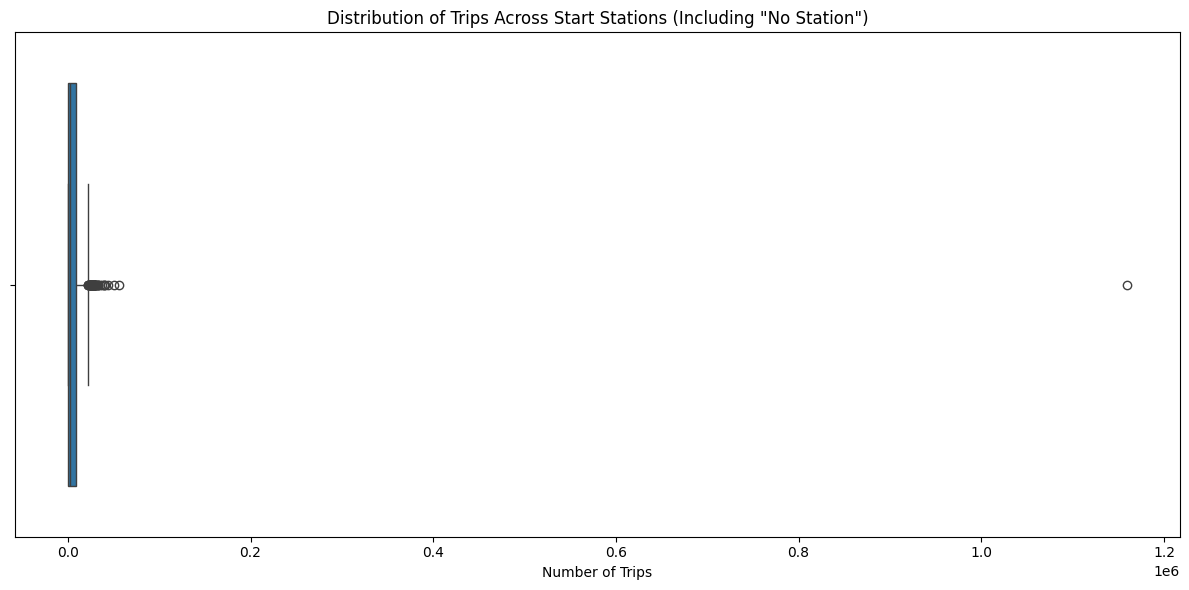

In [57]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=trips_per_start_station, x='num_trips')

# Customize the plot
plt.xlabel('Number of Trips')
plt.title('Distribution of Trips Across Start Stations (Including "No Station")')
plt.tight_layout()
plt.show()


In [55]:
# Group by the end station and count the number of trips
trips_per_end_station = df.groupby('end_station_name').size().reset_index(name='num_trips')

# Sort the stations by number of trips, descending
trips_per_end_station = trips_per_end_station.sort_values(by='num_trips', ascending=False)

# Display the results
print(trips_per_end_station)


                    end_station_name  num_trips
584                       No Station    1204644
315  Columbus Circle / Union Station      55458
575      New Hampshire Ave & T St NW      49678
66                    15th & P St NW      43587
199                    5th & K St NW      40709
..                               ...        ...
493              Links Dr & Wedge Dr          2
817                 tech trailer V-1          2
362      Eastern Market Metro/Pillar          1
531          Minnesota Ave & D St SE          1
658         Ring Rd & North Shore Dr          1

[818 rows x 2 columns]


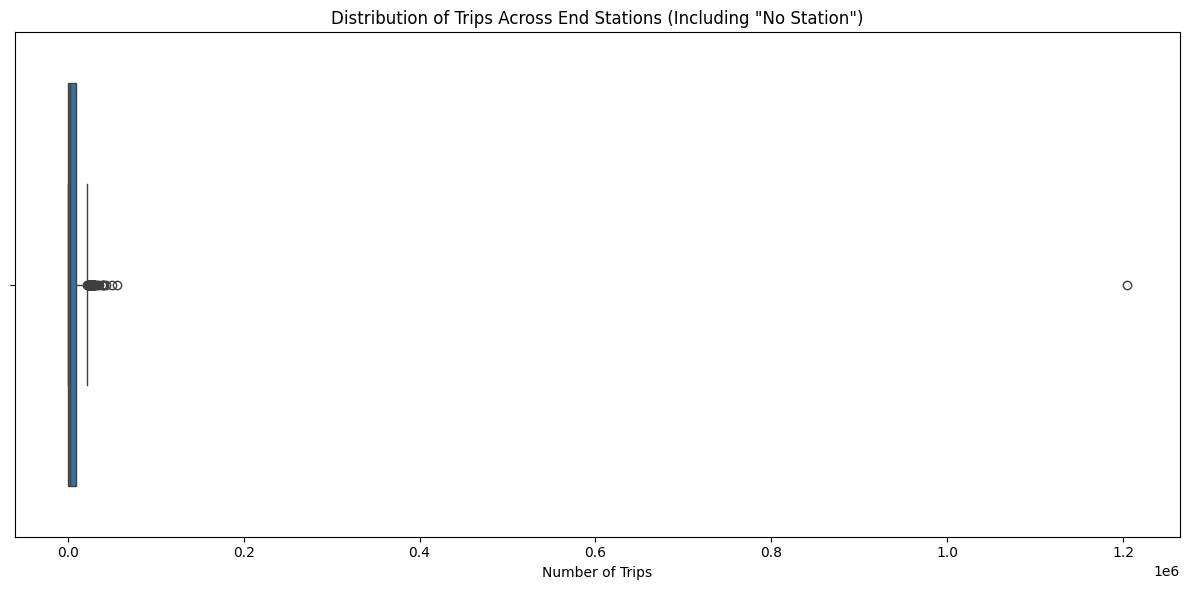

In [56]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=trips_per_end_station, x='num_trips')

# Customize the plot
plt.xlabel('Number of Trips')
plt.title('Distribution of Trips Across End Stations (Including "No Station")')
plt.tight_layout()
plt.show()


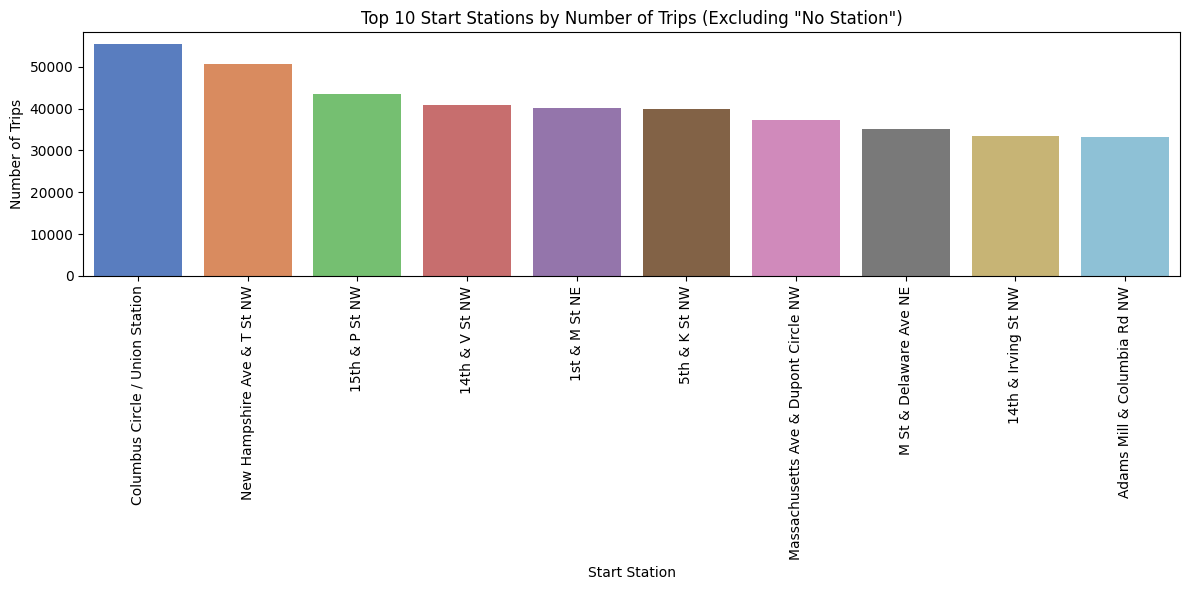

In [61]:
# Filter out rows where start_station_name is 'No Station'
filtered_trips = trips_per_start_station[trips_per_start_station['start_station_name'] != 'No Station']

# Plot the filtered data
plt.figure(figsize=(12, 6))
sns.barplot(x='start_station_name', y='num_trips', data=filtered_trips.head(10),  palette='muted')  # Top 10 stations
plt.xticks(rotation=90)
plt.xlabel('Start Station')
plt.ylabel('Number of Trips')
plt.title('Top 10 Start Stations by Number of Trips (Excluding "No Station")')
plt.tight_layout()
plt.show()


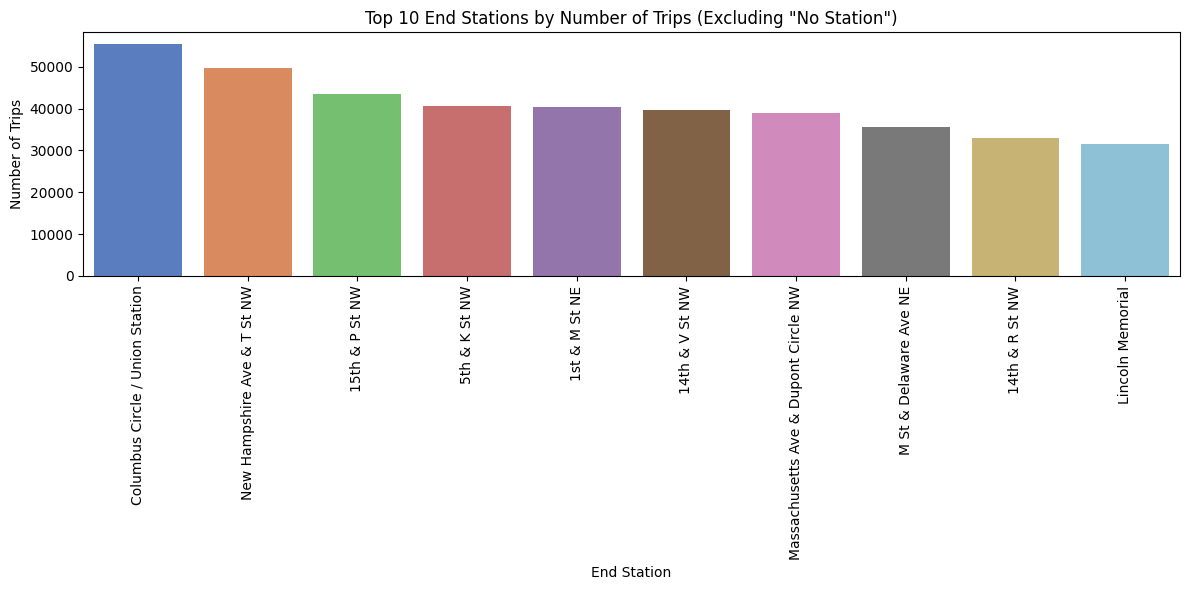

In [62]:
# Filter out rows where end_station_name is 'No Station'
filtered_trips = trips_per_end_station[trips_per_end_station['end_station_name'] != 'No Station']

# Plot the filtered data
plt.figure(figsize=(12, 6))
sns.barplot(x='end_station_name', y='num_trips', data=filtered_trips.head(10),  palette='muted')  # Top 10 stations
plt.xticks(rotation=90)
plt.xlabel('End Station')
plt.ylabel('Number of Trips')
plt.title('Top 10 End Stations by Number of Trips (Excluding "No Station")')
plt.tight_layout()
plt.show()

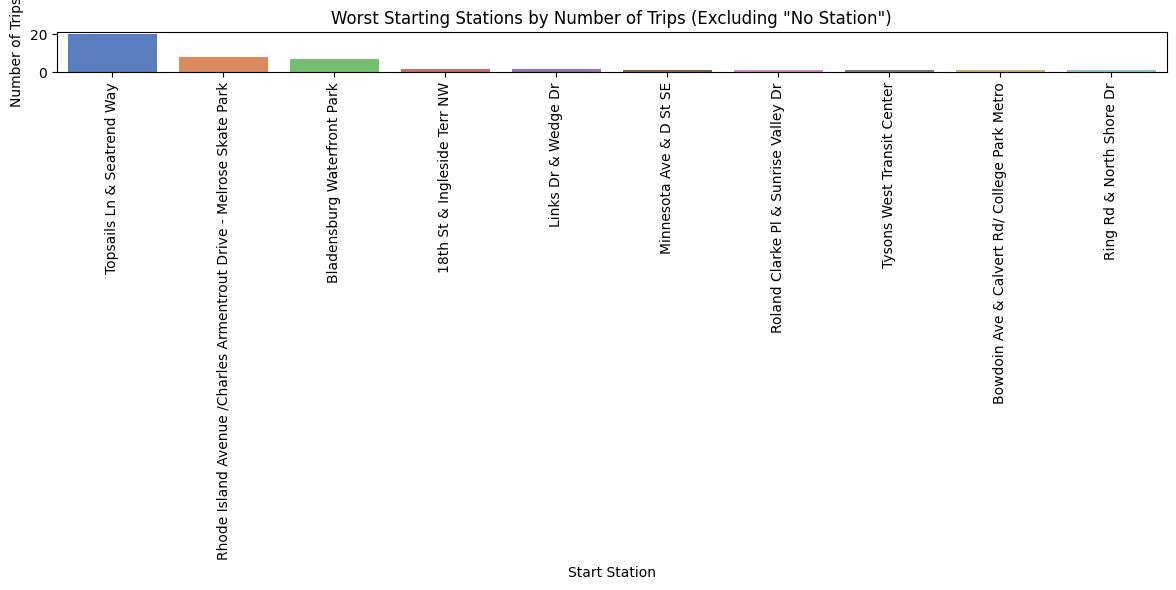

In [107]:
# Filter out rows where start_station_name is 'No Station'
filtered_trips = trips_per_start_station[trips_per_start_station['start_station_name'] != 'No Station']

# Plot the filtered data
plt.figure(figsize=(12, 6))
sns.barplot(x='start_station_name', y='num_trips', data=filtered_trips.tail(10),  palette='muted')  # Top 10 stations
plt.xticks(rotation=90)
plt.xlabel('Start Station')
plt.ylabel('Number of Trips')
plt.title('Worst Starting Stations by Number of Trips (Excluding "No Station")')
plt.tight_layout()
plt.show()

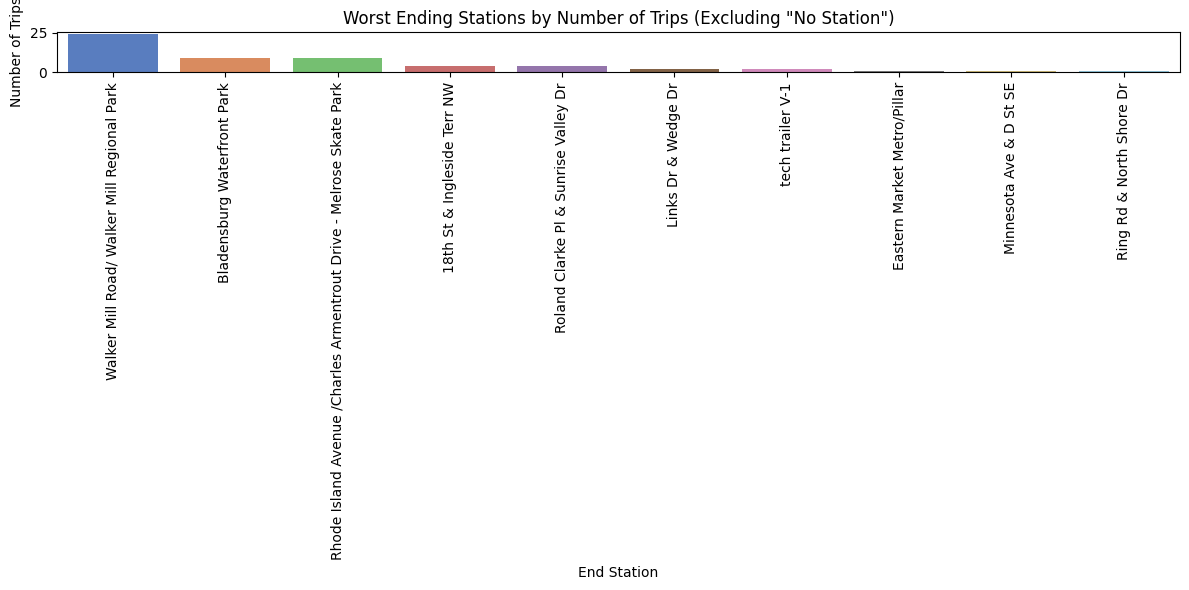

In [108]:
# Filter out rows where end_station_name is 'No Station'
filtered_trips = trips_per_end_station[trips_per_end_station['end_station_name'] != 'No Station']

# Plot the filtered data
plt.figure(figsize=(12, 6))
sns.barplot(x='end_station_name', y='num_trips', data=filtered_trips.tail(10),  palette='muted')  # Top 10 stations
plt.xticks(rotation=90)
plt.xlabel('End Station')
plt.ylabel('Number of Trips')
plt.title('Worst Ending Stations by Number of Trips (Excluding "No Station")')
plt.tight_layout()
plt.show()

In [84]:
# Group by start_station_name to get outbound trips
starting_trips = df.groupby('start_station_name').size().reset_index(name='starting_trips')

# Group by end_station_name to get ending trips
ending_trips = df.groupby('end_station_name').size().reset_index(name='ending_trips')

# Merge the two DataFrames on station name
trip_imbalance = pd.merge(starting_trips, ending_trips,
                          left_on='start_station_name',
                          right_on='end_station_name',
                          how='outer')

# Fill NaN with 0 for stations with only inbound or outbound trips
trip_imbalance = trip_imbalance.fillna(0)

# Rename columns for clarity
trip_imbalance.rename(columns={'start_station_name': 'station_name'}, inplace=True)

# Calculate imbalance (ending - starting)
trip_imbalance['imbalance'] = trip_imbalance['ending_trips'] - trip_imbalance['starting_trips']

# Sort by imbalance for analysis
trip_imbalance = trip_imbalance.sort_values(by='imbalance', ascending=False)

# Display the imbalance DataFrame
print(trip_imbalance.head(10))  # Top 10 stations with the highest imbalance


                               station_name  starting_trips  \
585                              No Station       1159602.0   
731  Thomas Jefferson St NW & Water/K St NW         10701.0   
409          Georgetown Harbor / 30th St NW         16356.0   
282          C & O Canal & Wisconsin Ave NW         16380.0   
231            9th St & Pennsylvania Ave NW         13216.0   
158                      34th & Water St NW          8979.0   
502              M St & Pennsylvania Ave NW         18435.0   
529           Metro Center / 12th & G St NW         17553.0   
222                           8th & H St NW         24257.0   
1                            10th & G St NW          9011.0   

                           end_station_name  ending_trips  imbalance  
585                              No Station     1204644.0    45042.0  
731  Thomas Jefferson St NW & Water/K St NW       14782.0     4081.0  
409          Georgetown Harbor / 30th St NW       20246.0     3890.0  
282          C & O Can

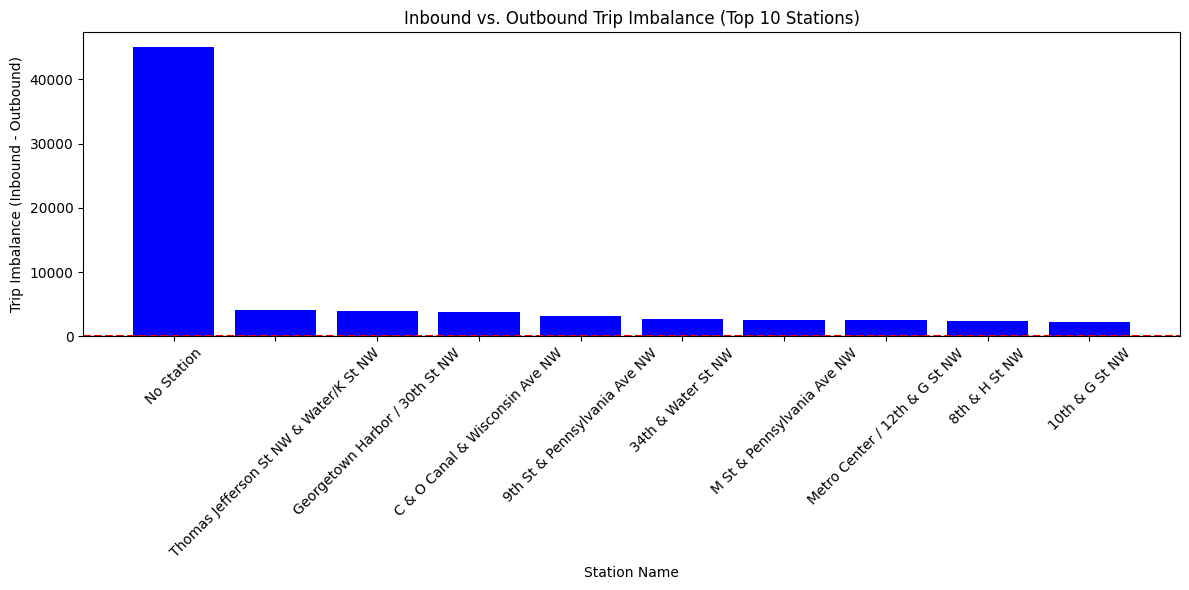

In [87]:
# Filter out rows where the station name is 'No stations'
top_imbalance = trip_imbalance[trip_imbalance['station_name'] != 'No Station'].head(10)

# Plot top 10 stations with the highest imbalance
top_imbalance = trip_imbalance.head(10)
plt.figure(figsize=(12, 6))
plt.bar(top_imbalance['station_name'], top_imbalance['imbalance'], color='blue')
plt.axhline(0, color='red', linestyle='--')  # Line for balanced stations
plt.xlabel('Station Name')
plt.ylabel('Trip Imbalance (Inbound - Outbound)')
plt.title('Inbound vs. Outbound Trip Imbalance (Top 10 Stations)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [89]:
# Convert the 'started_at' column to datetime objects
df['started_at'] = pd.to_datetime(df['started_at'])

# Extract the hour from the 'started_at' column
df['hour'] = df['started_at'].dt.hour

# Group by hour and count the number of rides
hourly_counts = df.groupby('hour')['ride_id'].count()

# Find the hour with the maximum number of rides
peak_hour = hourly_counts.idxmax()

print(f"The peak hour for bike rentals is: {peak_hour}")

The peak hour for bike rentals is: 17


The month with the highest number of rides is: 10


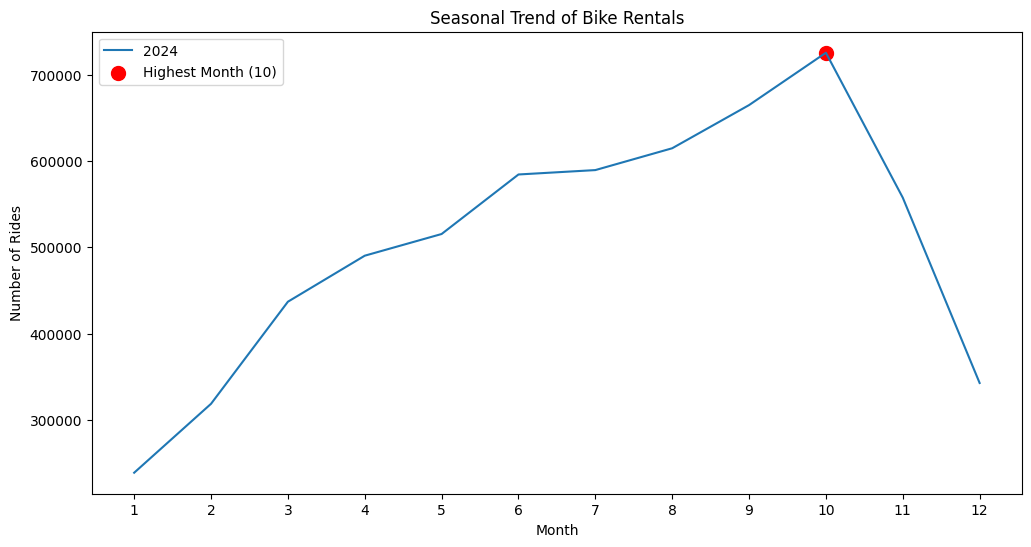

In [94]:
# Convert 'started_at' to datetime
df['started_at'] = pd.to_datetime(df['started_at'])

# Extract month and year
df['month'] = df['started_at'].dt.month
df['year'] = df['started_at'].dt.year

# Group by month and year, count rides
monthly_rides = df.groupby(['year', 'month'])['ride_id'].count().reset_index()

# Pivot for easier plotting
monthly_rides = monthly_rides.pivot(index='month', columns='year', values='ride_id')

# Plot the seasonal trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_rides)
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.ylabel('Number of Rides')
plt.title('Seasonal Trend of Bike Rentals')

# Find the month with the highest number of rides overall
highest_month = monthly_rides.sum(axis=1).idxmax()
print(f"The month with the highest number of rides is: {highest_month}")

#Highlight the highest month
plt.scatter(highest_month, monthly_rides.sum(axis=1).max(), color='red', s=100, label=f'Highest Month ({highest_month})')
plt.legend()
plt.show()

#K-Mean Clustering

In [102]:
#Use K-means clustering to put stations into categories, the categories are high, medium, and low

from sklearn.cluster import KMeans

# Assuming 'trips_per_start_station' DataFrame is available from previous code
# and contains 'start_station_name' and 'num_trips' columns.

# Prepare the data for KMeans
X = trips_per_start_station[['num_trips']]  # Use only 'num_trips' for clustering

# Initialize and fit the KMeans model with 3 clusters (high, medium, low)
kmeans = KMeans(n_clusters=3, random_state=0)  # Set random_state for reproducibility
kmeans.fit(X)

# Add cluster labels to the DataFrame
trips_per_start_station['cluster'] = kmeans.labels_

# Map cluster labels to categories
cluster_mapping = {
    0: 'low',
    1: 'medium',
    2: 'high'
}  # Adjust mapping based on actual cluster distribution

trips_per_start_station['category'] = trips_per_start_station['cluster'].map(cluster_mapping)

# Print or analyze the results
print(trips_per_start_station.head())

                  start_station_name  num_trips  cluster category
584                       No Station    1159602        1   medium
316  Columbus Circle / Union Station      55488        2     high
575      New Hampshire Ave & T St NW      50671        2     high
66                    15th & P St NW      43542        2     high
52                    14th & V St NW      40969        2     high


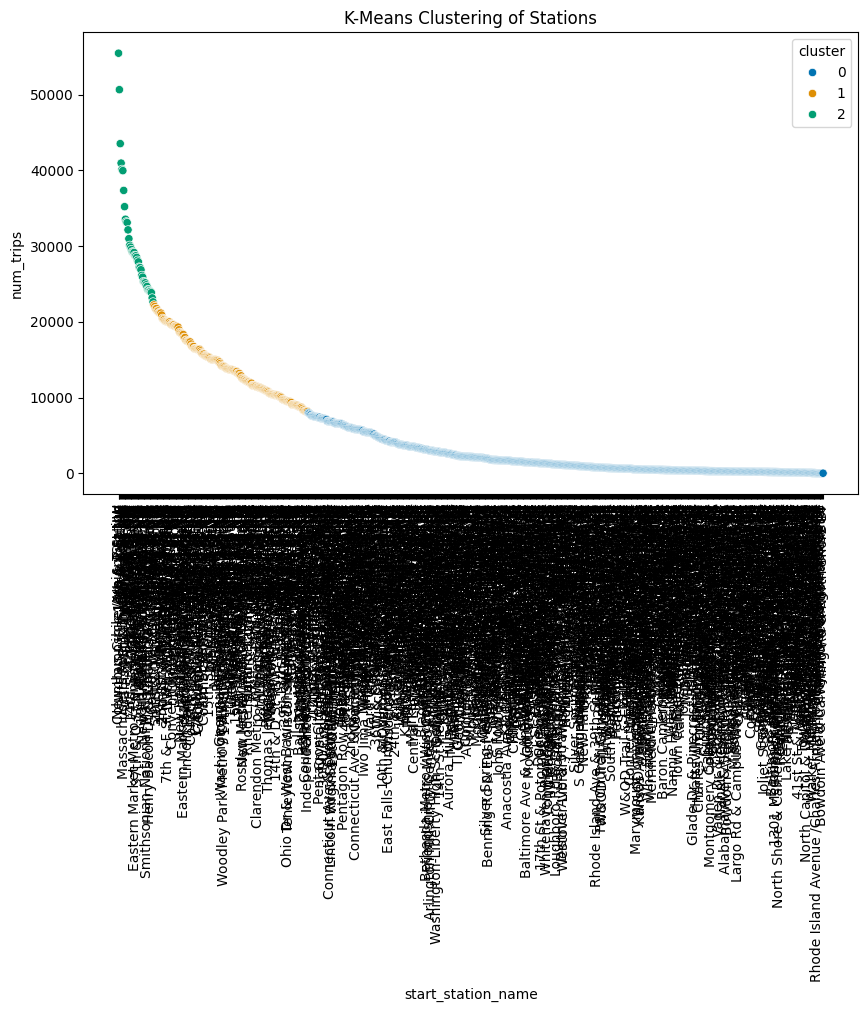

In [109]:
# You can further analyze the clusters, visualize them, etc.
# For instance, visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='start_station_name', y='num_trips', hue='cluster', data=station_data, palette='colorblind')
plt.xticks(rotation=90)
plt.title('K-Means Clustering of Stations')
plt.show()

In [111]:
# Create a copy of the DataFrame
df_copy = df.copy()

# Assuming 'trips_per_start_station' DataFrame is available from previous code
# and contains 'start_station_name' and 'num_trips' columns.

# Prepare the data for KMeans
X = trips_per_start_station[['num_trips']]  # Use only 'num_trips' for clustering

# Initialize and fit the KMeans model with 3 clusters (high, medium, low)
kmeans = KMeans(n_clusters=3, random_state=0)  # Set random_state for reproducibility
kmeans.fit(X)

# Add cluster labels to the DataFrame
trips_per_start_station['cluster'] = kmeans.labels_

# Map cluster labels to categories
cluster_mapping = {
    0: 'low',
    1: 'medium',
    2: 'high'
}  # Adjust mapping based on actual cluster distribution

trips_per_start_station['category'] = trips_per_start_station['cluster'].map(cluster_mapping)

# Merge the cluster information back into the main DataFrame
df_copy = pd.merge(df_copy, trips_per_start_station[['start_station_name', 'cluster', 'category']], on='start_station_name', how='left')

# Now df_copy contains the cluster information
print(df_copy.head())

            ride_id  rideable_type                       started_at  \
0  7423C99F4BD5CA4D   classic_bike 2024-07-14 02:28:12.002000+00:00   
1  C62B09A1D91AE9A1  electric_bike 2024-07-03 20:57:51.569000+00:00   
2  7443CAB2293B4A0E   classic_bike 2024-07-15 20:09:01.187000+00:00   
3  2BC3478A9E83046D   classic_bike 2024-07-31 20:26:34.406000+00:00   
4  11FDA598D980EE81   classic_bike 2024-07-31 20:26:16.461000+00:00   

                          ended_at                start_station_name  \
0 2024-07-14 02:30:24.390000+00:00              15th St & N Scott St   
1 2024-07-03 21:09:15.914000+00:00       Columbia Rd & Belmont St NW   
2 2024-07-15 20:26:56.526000+00:00  Hains Point/Buckeye & Ohio Dr SW   
3 2024-07-31 22:29:45.352000+00:00        Long Bridge Aquatic Center   
4 2024-07-31 22:29:32.309000+00:00        Long Bridge Aquatic Center   

   start_station_id                  end_station_name  end_station_id  \
0           31031.0        Clarendon Blvd & Pierce St         31016

In [113]:
df_copy = df_copy.drop('year', axis=1)


KeyError: "['year'] not found in axis"

In [114]:
df_copy.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,hour,month,cluster,category
0,7423C99F4BD5CA4D,classic_bike,2024-07-14 02:28:12.002000+00:00,2024-07-14 02:30:24.390000+00:00,15th St & N Scott St,31031.0,Clarendon Blvd & Pierce St,31016.0,38.890540,-77.080950,38.893438,-77.076389,member,6,2,7,0,low
1,C62B09A1D91AE9A1,electric_bike,2024-07-03 20:57:51.569000+00:00,2024-07-03 21:09:15.914000+00:00,Columbia Rd & Belmont St NW,31113.0,8th & V St NW,31134.0,38.920667,-77.043656,38.917716,-77.022684,member,2,20,7,2,high
2,7443CAB2293B4A0E,classic_bike,2024-07-15 20:09:01.187000+00:00,2024-07-15 20:26:56.526000+00:00,Hains Point/Buckeye & Ohio Dr SW,31273.0,Hains Point/Buckeye & Ohio Dr SW,31273.0,38.878433,-77.030230,38.878433,-77.030230,member,0,20,7,0,low
3,2BC3478A9E83046D,classic_bike,2024-07-31 20:26:34.406000+00:00,2024-07-31 22:29:45.352000+00:00,Long Bridge Aquatic Center,31950.0,Long Bridge Aquatic Center,31950.0,38.870561,-77.044095,38.870561,-77.044095,casual,2,20,7,0,low
4,11FDA598D980EE81,classic_bike,2024-07-31 20:26:16.461000+00:00,2024-07-31 22:29:32.309000+00:00,Long Bridge Aquatic Center,31950.0,Long Bridge Aquatic Center,31950.0,38.870561,-77.044095,38.870561,-77.044095,casual,2,20,7,0,low


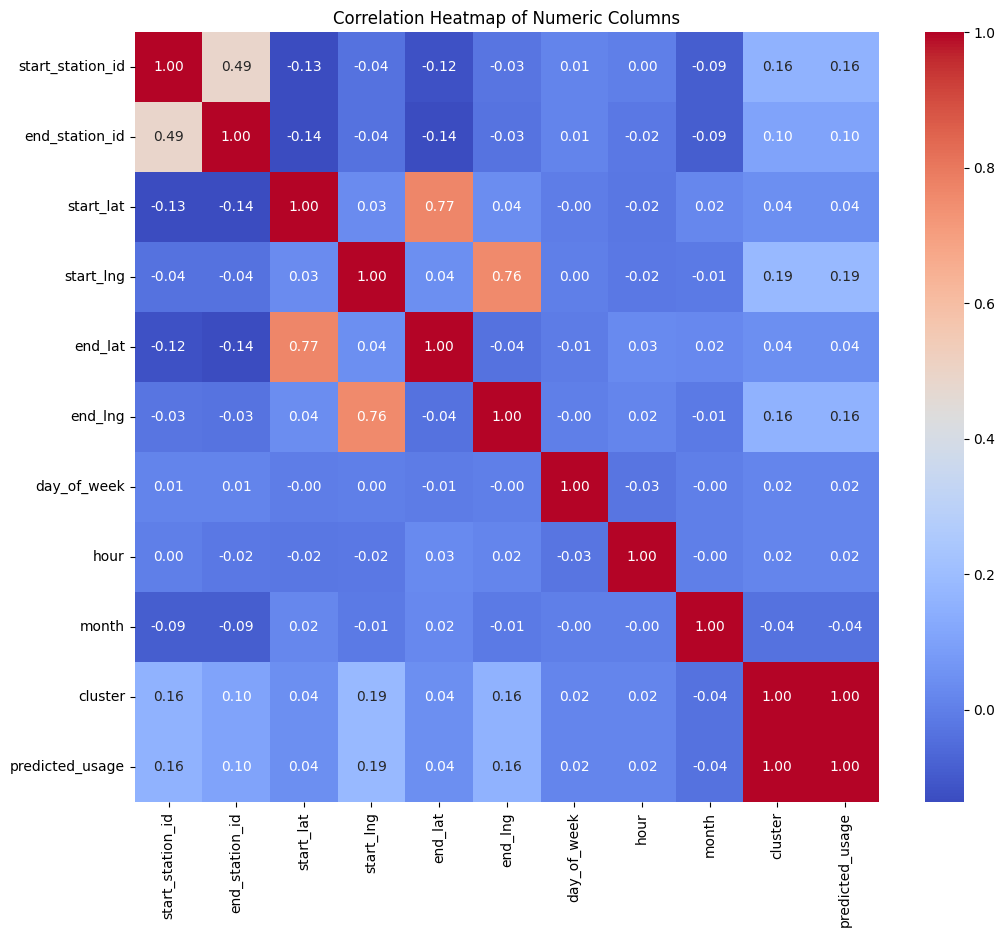

In [128]:
# Select only numeric columns for the heatmap
numeric_cols = df_copy.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

## Random Forest

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Assuming 'trip_imbalance' contains the relevant features
# Define your features (X) and target (y)
features = df_copy[['start_station_id', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]  # add all relevant features
target = df_copy['cluster']  # or whatever variable represents station usage

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=2)
rf.fit(X_train, y_train)

# Predict the usage on the test set
y_pred = rf.predict(X_test)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 17.3min


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 46.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    9.6s finished


Mean Absolute Error: 0.000964100083569048


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   17.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   44.5s finished


In [134]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE, MSE, and R²
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 0.000964100083569048
Mean Squared Error: 0.0011119595421978138
R-squared: 0.9984704785555573


## Xgboost

In [137]:
import xgboost as xgb

# Define your features (X) and target (y)
features = df_copy[['start_station_id', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]  # add all relevant features
target = df_copy['cluster']  # or whatever variable represents station usage

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=2)
xgb_model.fit(X_train, y_train)

# Predict the usage on the test set
y_pred = xgb_model.predict(X_test)

# Calculate MAE, MSE, and R²
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 0.009367294609546661
Mean Squared Error: 0.0021088903304189444
R-squared: 0.9970991611480713


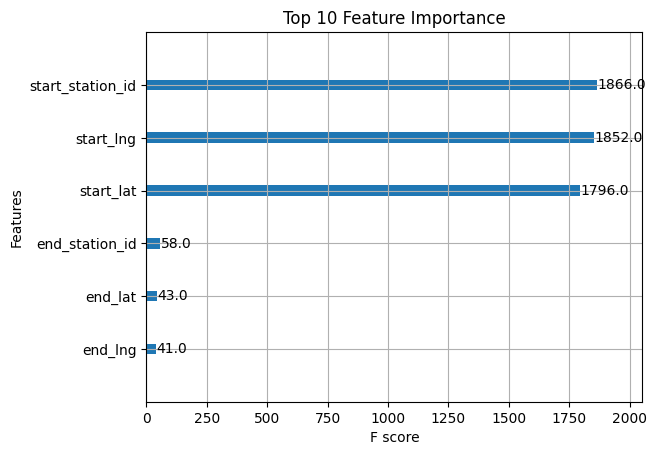

In [144]:
# Plot feature importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title='Top 10 Feature Importance')
plt.show()


#Save the model

In [145]:
import joblib

# Save the model
joblib.dump(xgb_model, 'xgboost_model.pkl')

# Load the model
loaded_model = joblib.load('xgboost_model.pkl')
